In [97]:
import sys
sys.path.append("/home/hugo/projetos-doutorado/Appliance-Energy-Prediction")
import pandas as pd
from pca_fts.PcaSarimax import PcaSarimax
from pyFTS.benchmarks import Measures
import matplotlib.pyplot as plt
from pyFTS.common import Util
import datetime
import statistics
import math
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

## Aux functions

In [98]:
def sample_first_prows(data, perc=0.75):
    return data.head(int(len(data)*(perc)))

In [99]:
# convert series to supervised learning
def series_to_supervised_miso(data, n_in, n_out, endog_var, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [(df.columns[j]+'(t-%d)' % (i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df[endog_var].shift(-i))
		if i == 0:
			names += [(endog_var+'(t)')]
		else:
			names += [(endog_var+'(t+%d)' % (i))]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [100]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame) 
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

## Dataset Smart Home with Weather Information

In [105]:
df = pd.read_csv('/home/hugo/projetos-doutorado/Appliance-Energy-Prediction/data/HomeC.csv')
data = df.drop(labels=['icon','summary','cloudCover', 'House overall [kW]', 'time'], axis=1)
data = data.loc[0: : 10]
data
data.dropna(inplace=True)
data = clean_dataset(data)
data.head()

/home/hugo/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0,27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,use [kW],gen [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],...,temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,windBearing,precipIntensity,dewPoint,precipProbability
0,0.932833,0.003483,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,0.013083,0.000417,...,36.14,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0
10,1.585083,0.003417,0.000050,0.022100,0.678733,0.440200,0.121450,0.007433,0.013583,0.000350,...,36.14,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0
20,0.533817,0.003450,0.000000,0.020633,0.062967,0.270033,0.004950,0.007033,0.013117,0.000750,...,36.14,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0
30,1.190950,0.003083,0.000217,0.387400,0.061883,0.256867,0.004933,0.101783,0.012533,0.000700,...,36.14,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0
40,1.582083,0.003067,0.000050,0.022050,0.681717,0.242433,0.005550,0.122400,0.013550,0.000567,...,36.14,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0


## Dataset Smart Home with Weather Information, Lag = 1, t+1

In [106]:
data = series_to_supervised_miso(data, 1, 1,endog_var='use [kW]')
data.head()

,use [kW](t-1),gen [kW](t-1),Dishwasher [kW](t-1),Furnace 1 [kW](t-1),Furnace 2 [kW](t-1),Home office [kW](t-1),Fridge [kW](t-1),Wine cellar [kW](t-1),Garage door [kW](t-1),Kitchen 12 [kW](t-1),...,humidity(t-1),visibility(t-1),apparentTemperature(t-1),pressure(t-1),windSpeed(t-1),windBearing(t-1),precipIntensity(t-1),dewPoint(t-1),precipProbability(t-1),use [kW](t)
10,0.932833,0.003483,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,0.013083,0.000417,...,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,1.585083
20,1.585083,0.003417,0.000050,0.022100,0.678733,0.440200,0.121450,0.007433,0.013583,0.000350,...,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,0.533817
30,0.533817,0.003450,0.000000,0.020633,0.062967,0.270033,0.004950,0.007033,0.013117,0.000750,...,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,1.190950
40,1.190950,0.003083,0.000217,0.387400,0.061883,0.256867,0.004933,0.101783,0.012533,0.000700,...,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,1.582083
50,1.582083,0.003067,0.000050,0.022050,0.681717,0.242433,0.005550,0.122400,0.013550,0.000567,...,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,0.837000


## Model: PcaSarimax - PCA-SARIMAX

### Define SARIMAX parameters 

In [7]:
pca_sarimax = PcaSarimax(n_components = 2,
                       endogen_variable = 'use [kW](t-1)',
                       order = [0, 0, 0],
                       seasonal_order = [0,0,0,0])

In [8]:
df_train = data.loc[:,'use [kW](t-1)':'precipProbability(t-1)']
train = sample_first_prows(data, perc=0.30)

In [9]:
reduced = pca_sarimax.apply_pca(train)
reduced.head(2)

,C0,C1,use [kW](t-1)
0,-0.137571,-0.220618,0.932833
1,-0.317482,0.483682,1.585083


In [10]:
exog = reduced.drop(labels=['use [kW](t-1)'], axis=1)
exog.head(2)

,C0,C1
0,-0.137571,-0.220618
1,-0.317482,0.483682


In [11]:
endog = reduced['use [kW](t-1)']
endog.head(3)

0    0.932833
1    1.585083
2    0.533817
Name: use [kW](t-1), dtype: float64

In [12]:
train_y = endog
train_X = exog

In [ ]:
# Define arimax paraters using the embedded data 
# from pmdarima.arima import auto_arima
# sarimax_model = auto_arima(train_y,
#                        exogenous= train_X,
#                        test='adf',
#                        start_p=0,
#                        start_q=0,
#                        max_p=5,
#                        max_q=5,
#                        start_Q=0,
#                        start_P=0,
#                        max_P=5,
#                        max_Q=5,
#                        m=7,
#                        seasonal=True,
#                        d=None,
#                        D=1,
#                        max_D=5,
#                        trace=True,
#                        error_action='ignore',
#                        suppress_warnings=True,
#                        stepwise=True)
# #                        n_fits = 50)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=28245.212, Time=3.74 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=21913.489, Time=23.21 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=86.24 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=28243.214, Time=5.50 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=25419.717, Time=7.34 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=20519.374, Time=45.29 sec
 ARIMA(1,0,0)(3,1,0)[7] intercept   : AIC=19824.193, Time=58.00 sec
 ARIMA(1,0,0)(4,1,0)[7] intercept   : AIC=19427.974, Time=82.41 sec
 ARIMA(1,0,0)(5,1,0)[7] intercept   : AIC=19133.263, Time=137.18 sec
 ARIMA(1,0,0)(5,1,1)[7] intercept   : AIC=inf, Time=348.57 sec
 ARIMA(1,0,0)(4,1,1)[7] intercept   : AIC=inf, Time=210.98 sec


In [15]:
# Performing stepwise search to minimize aic
#  ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=28245.212, Time=3.74 sec
#  ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=21913.489, Time=23.21 sec
#  ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=86.24 sec
#  ARIMA(0,0,0)(0,1,0)[7]             : AIC=28243.214, Time=5.50 sec
#  ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=25419.717, Time=7.34 sec
#  ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=20519.374, Time=45.29 sec
#  ARIMA(1,0,0)(3,1,0)[7] intercept   : AIC=19824.193, Time=58.00 sec
#  ARIMA(1,0,0)(4,1,0)[7] intercept   : AIC=19427.974, Time=82.41 sec
#  ARIMA(1,0,0)(5,1,0)[7] intercept   : AIC=19133.263, Time=137.18 sec
#  ARIMA(1,0,0)(5,1,1)[7] intercept   : AIC=inf, Time=348.57 sec
#  ARIMA(1,0,0)(4,1,1)[7] intercept   : AIC=inf, Time=210.98 sec


### Test the model with the best parameters 

In [16]:
pca_arimax = PcaSarimax(n_components = 2,
                       endogen_variable = 'use [kW](t-1)',
                       order=[4,0,0],
                       seasonal_order=[5,1,0,7])

In [26]:
df_train = data.loc[:,'use [kW](t-1)':'precipProbability(t-1)']
df_test = data.loc[:,'gen [kW](t-1)':'use [kW](t)']
train = sample_first_prows(df_train,0.75)
test = df_test.iloc[max(train.index):]

In [9]:
# model, sarimax, pca_reduced_train = pca_arimax.run_train_model(train)

In [10]:
# sarimax.summary()

In [11]:
# pca_reduced_train.head(2)

In [12]:
#ALtera o nome da columa porque o modelo utiliza esse label como variável endogena 
# test.rename(columns = {'use [kW](t)': 'use [kW](t-1)'}, inplace = True)
# start = len(train)
# end = len(train) + len(test) -1
# forecast, pca_reduced_test = pca_arimax.run_test_model(test, sarimax,start,end)

In [13]:
# forecast

In [14]:
#pca_reduced_test['Appliances(t-1)'].head(2)
# pca_reduced_test.head(5)

In [15]:
# print(Measures.rmse(pca_reduced_test['use [kW](t-1)'],forecast))
# print(Measures.mape(pca_reduced_test['use [kW](t-1)'],forecast))

## Model: PcaSarimax - PCA-SARIMAX - Final model 

In [ ]:
#ARIMA(1,0,0)(1,1,0)[7] ==> 1.372592	0.833335	327.091827	34.337999      
#ARIMA(0,0,1)(0,1,1)[7] ==> 1.298641	0.729507	291.425668	28.129435
#ARIMA(1,0,0)(0,1,1)[7] ==> 1.284234	0.716202	292.696034	26.853493
#ARIMA(1,0,0)(1,0,0)[7] ==> 0.996471	0.579249	274.727737	27.777424
#ARIMA(1,0,0)(1,0,1)[7] ==> 0.994874	0.577666	272.759379	27.534379
#ARIMA(2,0,0)(1,0,0)[7] ==> 1.293463	0.728866	297.1769	28.026641
#ARIMA(1,0,1)(1,0,1)[7] ==> 1.290961e+65	1.468332e+64	1.069531e+66	29.484988
#ARIMA(1,0,0)(2,0,1)[7] ==> 0.994599	0.577157	272.337254	27.458885
#ARIMA(1,0,0)(2,0,1)[7] ==> 0.99471	0.577162	272.186821	27.424954
#ARIMA(1,0,0)(3,0,2)[7] ==> 0.99471	0.577162	272.186821	27.424954
#ARIMA(1,0,0)(4,0,2)[7] ==> 0.994843	0.57759	272.146911	27.471431

In [107]:
pca_sarimax = PcaSarimax(n_components = 2,
                       endogen_variable = 'use [kW](t-1)',
                       order=[1,0,0],
                       seasonal_order=[2,0,1,7])

## Sliding Window PyFTS: PCA-SARIMAX

/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


--------------------
training window 0


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 15:10:13] getting statistics


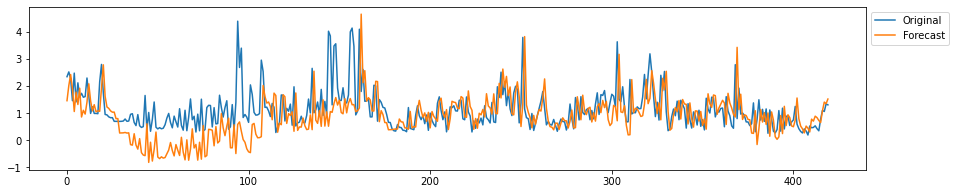

/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


--------------------
training window 1679


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 15:10:44] getting statistics


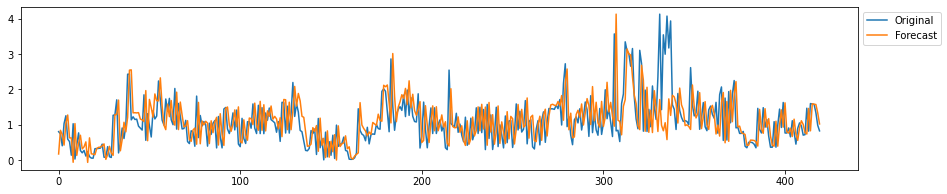

/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


--------------------
training window 3358


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 15:12:41] getting statistics


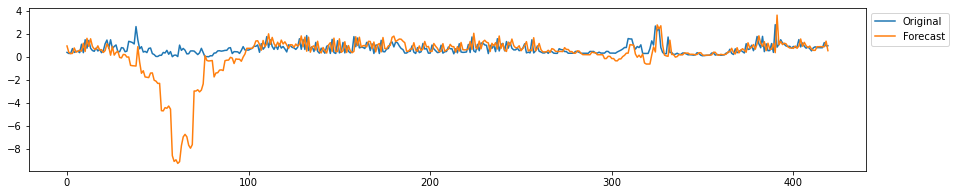

/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


--------------------
training window 5037


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 15:13:11] getting statistics


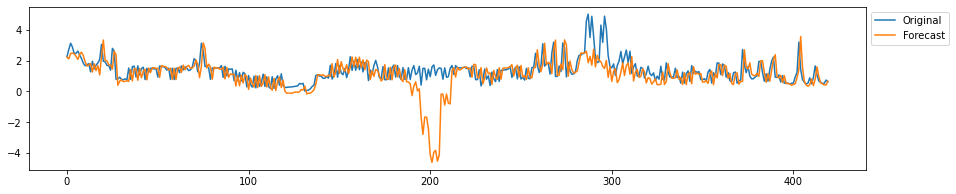

/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


--------------------
training window 6716


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 15:14:01] getting statistics


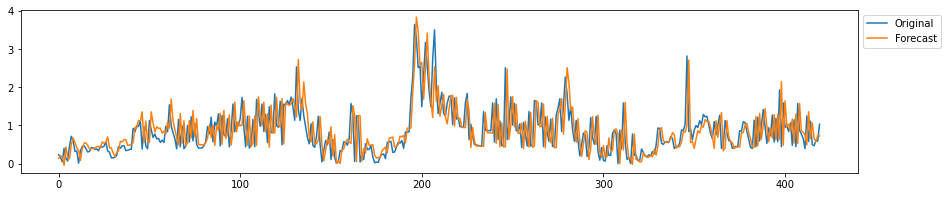

/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


--------------------
training window 8395


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 15:14:26] getting statistics


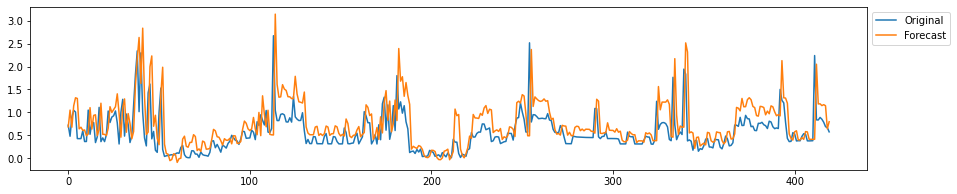

/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


--------------------
training window 10074
[ 15:15:28] getting statistics


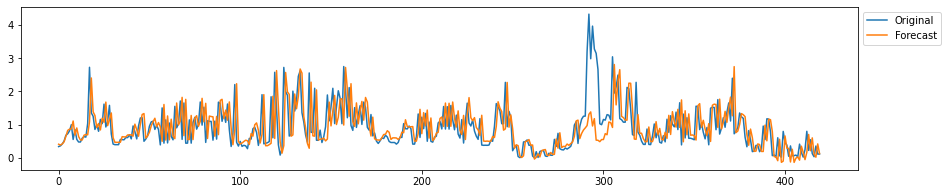

/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


--------------------
training window 11753
[ 15:15:57] getting statistics


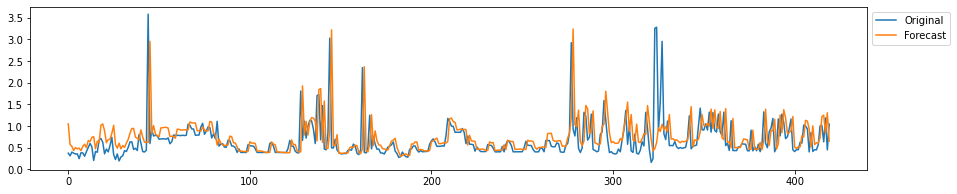

--------------------
training window 13432


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 15:16:30] getting statistics


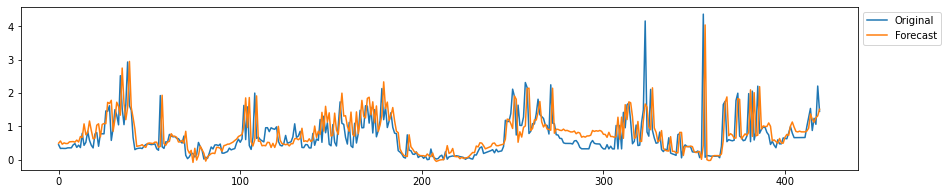

--------------------
training window 15111


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 15:16:52] getting statistics


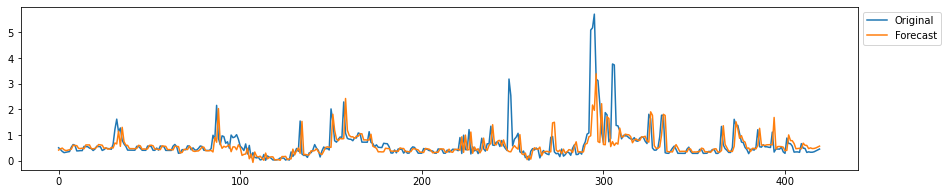

--------------------
training window 16790


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 15:17:04] getting statistics


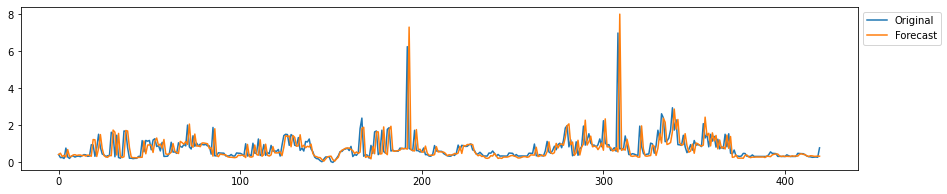

--------------------
training window 18469


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 15:17:28] getting statistics


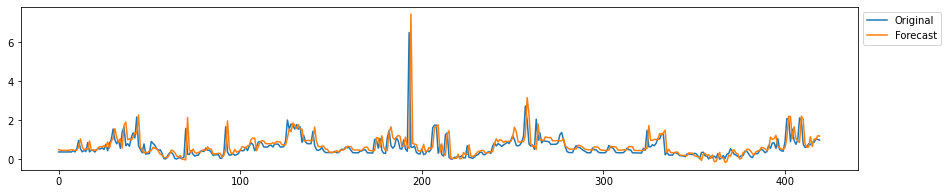

--------------------
training window 20148


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 15:17:53] getting statistics


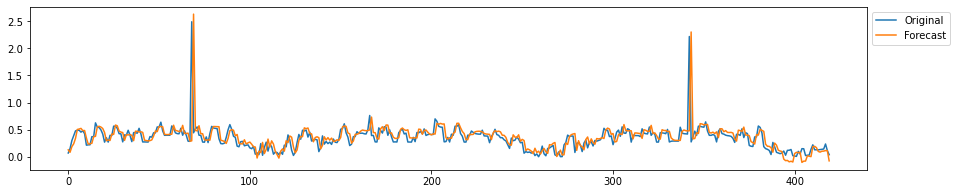

--------------------
training window 21827


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 15:18:02] getting statistics


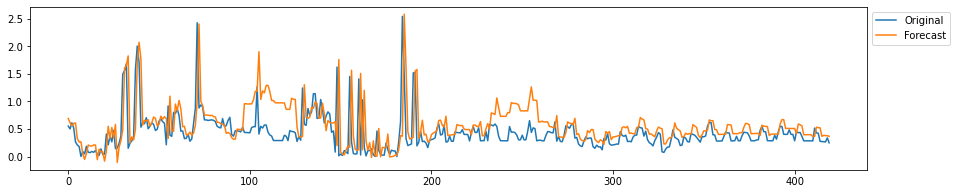

--------------------
training window 23506


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 15:18:23] getting statistics


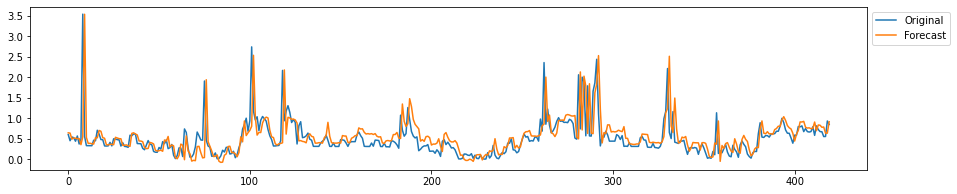

--------------------
training window 25185


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 15:18:33] getting statistics


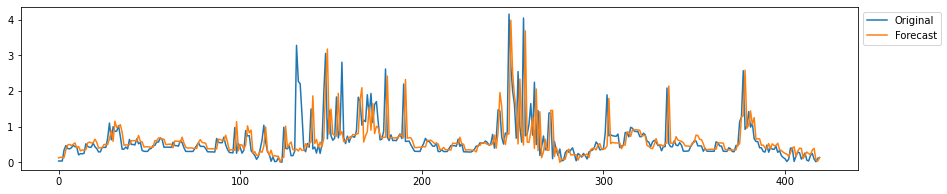

--------------------
training window 26864


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 15:18:54] getting statistics


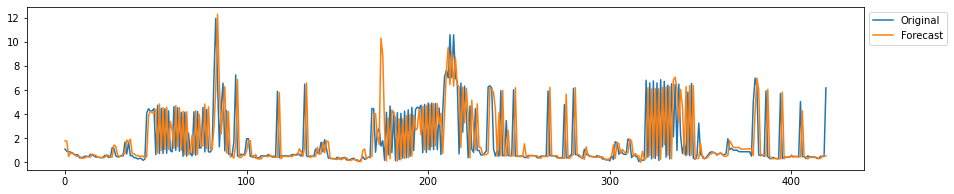

--------------------
training window 28543


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 15:19:04] getting statistics


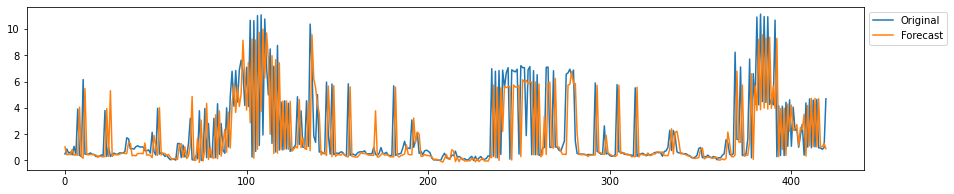

--------------------
training window 30222


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 15:19:24] getting statistics


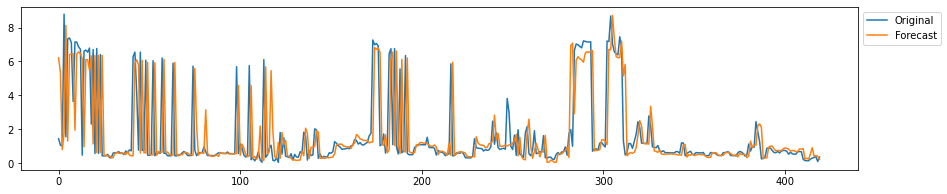

/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


--------------------
training window 31901


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 15:19:34] getting statistics


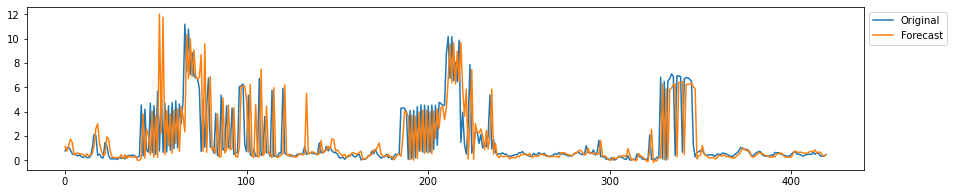

--------------------
training window 33580


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 15:19:44] getting statistics


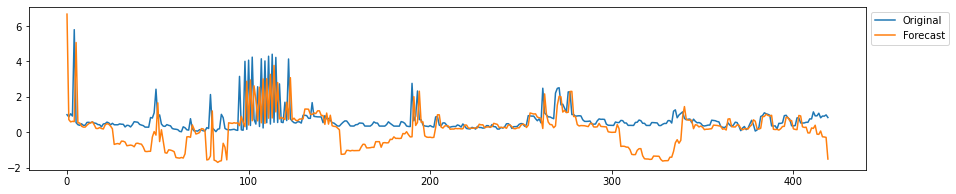

--------------------
training window 35259


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 15:19:55] getting statistics


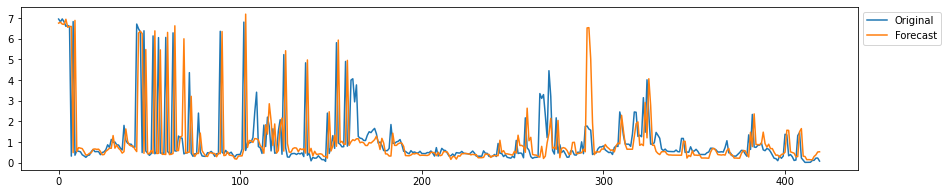

--------------------
training window 36938


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 15:20:19] getting statistics


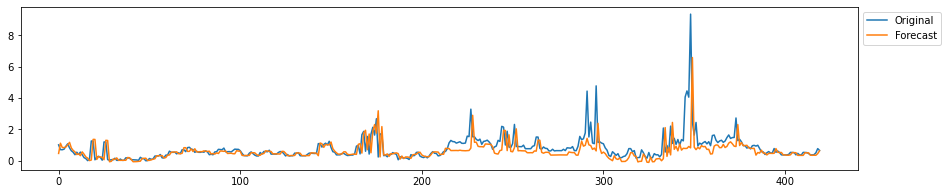

--------------------
training window 38617


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 15:20:40] getting statistics


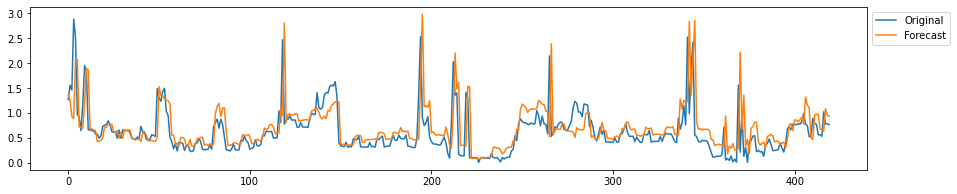

/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


--------------------
training window 40296


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 15:20:52] getting statistics


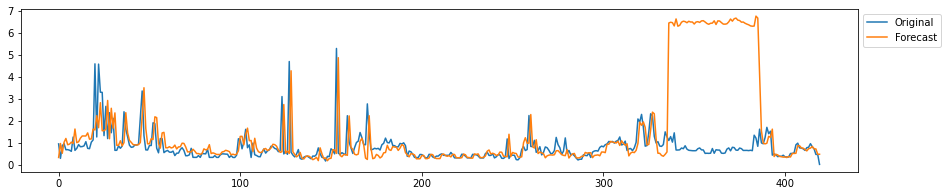

--------------------
training window 41975


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 15:21:05] getting statistics


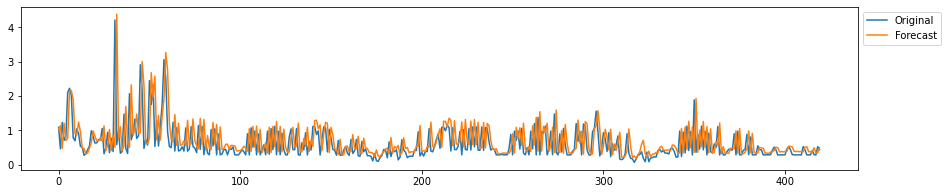

--------------------
training window 43654


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 15:21:17] getting statistics


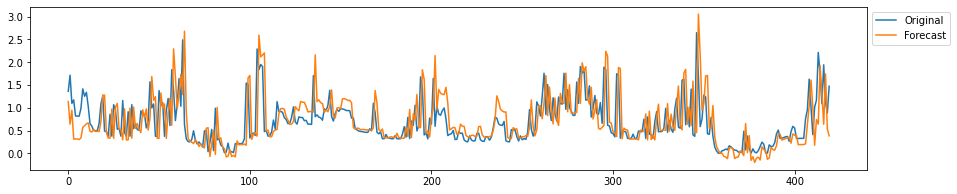

--------------------
training window 45333


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 15:22:07] getting statistics


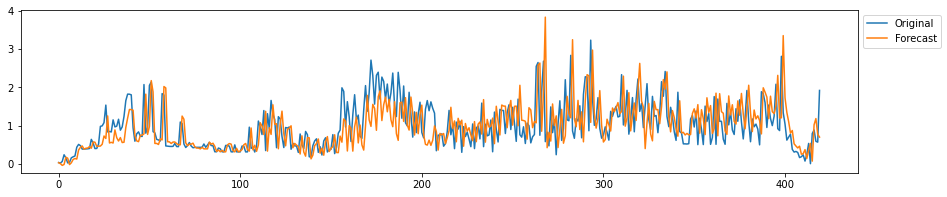

--------------------
training window 47012


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 15:22:55] getting statistics


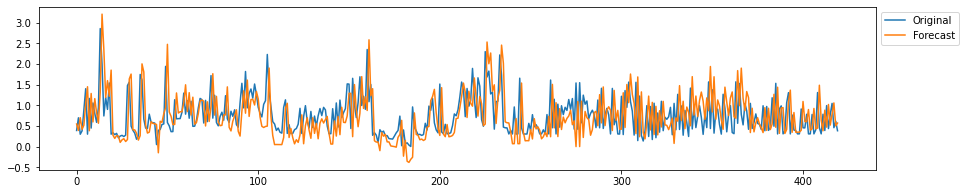

--------------------
training window 48691


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 15:23:05] getting statistics


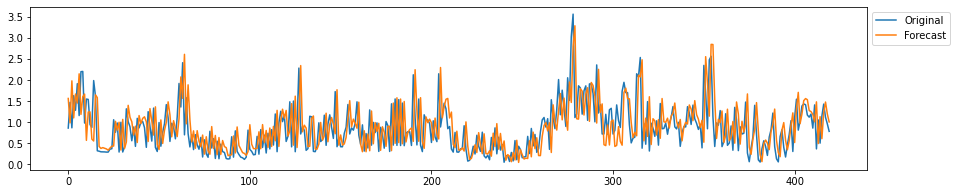

In [108]:
result = {
     "window": [],
     "rmse": [],
     "mae": [],
     "mape": [],
     "smape": []
}

tam = len(data)
n_windows = 30
windows_length = math.floor(tam / n_windows)
for ct, ttrain, ttest in Util.sliding_window(data, windows_length, 0.75, inc=1):
    if len(ttest) > 0:

        data_train = ttrain.loc[:,'use [kW](t-1)':'precipProbability(t-1)']
        data_test = ttest.loc[:,'gen [kW](t-1)':'use [kW](t)']
        
        #ALtera o nome da columa porque o modelo utiliza esse label como variável endogena 
        data_test.rename(columns = {'use [kW](t)': 'use [kW](t-1)'}, inplace = True)
        
        start = len(data_train)
        end = len(data_train)+ len(data_test) -1
        #appliance = ttest['Appliances_t+1'].reset_index()
        
        print('-' * 20)
        print(f'training window {(ct)}')
        model, sarimax, pca_reduced_train = pca_sarimax.run_train_model(data_train)
        forecast, pca_reduced_test = pca_sarimax.run_test_model(data_test,sarimax,start,end)
        
        print("[{0: %H:%M:%S}]".format(datetime.datetime.now()) + f" getting statistics")
        rmse = Measures.rmse(pca_reduced_test['use [kW](t-1)'],forecast)
        mape = Measures.mape(pca_reduced_test['use [kW](t-1)'],forecast)
        smape = Measures.smape(pca_reduced_test['use [kW](t-1)'],forecast)
        
#         forecast = pd.DataFrame(forecast)
#         forecast.fillna(forecast.mean(),inplace=True)
#         forecast = np.array(forecast).reshape(-1)
        mae = mean_absolute_error(pca_reduced_test['use [kW](t-1)'], forecast)
    
        # Grafico de comparação Original x Previsto para cada janela
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
        ax.plot(pca_reduced_test['use [kW](t-1)'], label='Original')
        ax.plot(forecast, label='Forecast')
        handles, labels = ax.get_legend_handles_labels()
        lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
        plt.show()
        
        
        result["rmse"].append(rmse)
        result["mae"].append(mae)
        result["mape"].append(mape)
        result["smape"].append(smape)
        result["window"].append(ct)
        
measures = pd.DataFrame(result)

In [109]:
measures

,window,rmse,mae,mape,smape
0,0,0.906578,0.653643,66.797458,34.648827
1,1679,0.723084,0.533347,93.197974,26.343902
2,3358,1.766584,0.855993,414.675371,40.200512
3,5037,1.061687,0.654293,65.149893,27.959436
4,6716,0.540738,0.400874,107.715800,25.610658
5,8395,0.467130,0.314251,97.327583,25.868636
6,10074,0.664876,0.449209,83.451827,26.151834
7,11753,0.486043,0.261634,40.837153,15.465342
8,13432,0.555434,0.339972,91.383093,25.039241
9,15111,0.548282,0.252471,46.942574,18.084895


In [110]:
### Mean Statistics PCA-SARIMAX

In [111]:
final_result = {
     "rmse": [],
     "mae":[],
     "mape": [],
     "smape": []
}

final_result["rmse"].append(statistics.mean(measures['rmse']))
final_result["mae"].append(statistics.mean(measures['mae']))
final_result["mape"].append(statistics.mean(measures['mape']))
final_result["smape"].append(statistics.mean(measures['smape']))
        
final_measures_pca = pd.DataFrame(final_result)

print("Mean Statistics PCA-SARIMAX (test): ")
final_measures_pca

Mean Statistics PCA-SARIMAX (test): 


,rmse,mae,mape,smape
0,0.994599,0.577157,272.337254,27.458885
